In [18]:
%matplotlib inline


import sys
import os.path
sys.path.append(os.path.join('..', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
import pylab

import filtering
from timer import Timer
import threading

Compiling with /usr/local/bin/clang-omp


In [14]:
def wait_for_event(e):
    """Wait for the event to be set before doing anything"""
    logging.debug('wait_for_event starting')
    event_is_set = e.wait()
    logging.debug('event set: %s', event_is_set)


In [38]:
def py_median_3x3(image, iterations=10, num_threads=1):
    ''' repeatedly filter with a 3x3 median '''
    tmpA = image.copy()
    tmpB = np.empty_like(tmpA)
    
    for i in range(iterations):
        filtering.median_3x3(tmpA, tmpB, 0, 1)
        # swap direction of filtering
        tmpA, tmpB = tmpB, tmpA

    return tmpA


In [52]:
def parallel_function(tmpA, tmpB, t, num_threads, events_list, iterations):
    for i in range(iterations):
        filtering.median_3x3(tmpA, tmpB, t, num_threads)
        events_list[t].set()
        tmpA, tmpB = tmpB, tmpA
        
        for e in events_list:
            if e!=t:
                e.wait()
    

In [56]:
def py_median_3x3(image, iterations=10, num_threads=4):
    ''' repeatedly filter with a 3x3 median '''
    tmpA = image.copy()
    tmpB = np.empty_like(tmpA)
    
    
    events_list = []
    threads_list = []
    
    for t in range(num_threads):
        
        e = threading.Event()
        events_list.append(e)
        t = threading.Thread(target=parallel_function, args=(tmpA, tmpB, t, num_threads, events_list, iterations))
        t.start()
        threads_list.append(t)
        
    
    for thread in threads_list:
        thread.join()
    
    
#     for i in range(iterations):
#         filtering.median_3x3(tmpA, tmpB, 0, 1)
#         # swap direction of filtering
#         tmpA, tmpB = tmpB, tmpA

    return tmpA


In [57]:
def numpy_median(image, iterations=10):
    ''' filter using numpy '''
    for i in range(iterations):
        padded = np.pad(image, 1, mode='edge')
        stacked = np.dstack((padded[:-2,  :-2], padded[:-2,  1:-1], padded[:-2,  2:],
                             padded[1:-1, :-2], padded[1:-1, 1:-1], padded[1:-1, 2:],
                             padded[2:,   :-2], padded[2:,   1:-1], padded[2:,   2:]))
        image = np.median(stacked, axis=2)

    return image

1.62996602058 seconds for 10 filter passes.


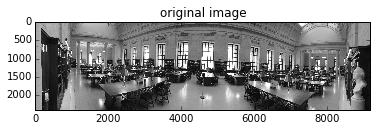

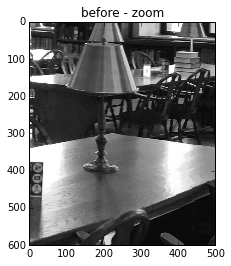

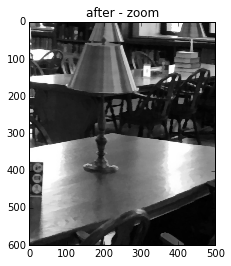

In [58]:

input_image = np.load('image.npz')['image'].astype(np.float32)

pylab.gray()

pylab.imshow(input_image)
pylab.title('original image')

pylab.figure()
pylab.imshow(input_image[1200:1800, 3000:3500])
pylab.title('before - zoom')

# verify correctness
from_cython = py_median_3x3(input_image, 2, 5)
from_numpy = numpy_median(input_image, 2)
assert np.all(from_cython == from_numpy)

with Timer() as t:
    new_image = py_median_3x3(input_image, 10, 8)

pylab.figure()
pylab.imshow(new_image[1200:1800, 3000:3500])
pylab.title('after - zoom')

print("{} seconds for 10 filter passes.".format(t.interval))
pylab.show()
